# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
# Imports of all used packages and libraries
import sys
import os
import git
import glob
from collections import defaultdict

In [2]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [3]:
git_root

'/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/reward_competition_extention'

In [4]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [7]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu
import scipy

In [8]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [9]:
import utilities.helper
import trodes.read_exported

In [10]:
from pathlib import Path

In [11]:
import shutil

In [12]:
FONTSIZE = 20

In [13]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

## Inputs & Data

Explanation of each input and where it comes from.

In [14]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [15]:
LFP_SPECTRAL_DF = pd.read_pickle("../2024_01_30_rce2_spectral_preprocessing/proc/rce_pilot_2_10_per_trial_spectral_bans_sleap.pkl")

In [16]:
session_types = ["training", "omission", "both_rewarded", "novel"]

In [17]:
OUTCOME_TO_COLOR = {"both_rewarded": "green", 
"novel_lose": "#e67073",
"novel_win": "#93a5da",
"standard_lose": "#951a1d",
"standard_rewarded": "#0499af",
"standard_win": "#3853a3",
"omission_rewarded": "pink",
"omission": "orange"}

In [18]:
id_to_color = {'1.1': "red", '1.2': "blue", '1.4': "green"}

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [19]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [20]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




In [21]:
LFP_SPECTRAL_DF.columns

Index(['tracked_subject', 'box_number', 'sleap_name', 'video_name',
       'current_subject', 'tone_start_frame', 'reward_start_frame',
       'tone_stop_frame', 'condition', 'competition_closeness',
       ...
       'baseline_subject_thorax_to_reward_port',
       'baseline_subject_thorax_velocity', 'baseline_video_timestamps',
       'trial_agent_locations', 'trial_agent_thorax_to_reward_port',
       'trial_agent_thorax_velocity', 'trial_subject_locations',
       'trial_subject_thorax_to_reward_port', 'trial_subject_thorax_velocity',
       'trial_video_timestamps'],
      dtype='object', length=275)

## Power plots

In [22]:
LFP_SPECTRAL_DF["trial_label"]

0        win
1       lose
2       lose
3       lose
4       lose
        ... 
1364    lose
1365    lose
1366    lose
1367    lose
1368    lose
Name: trial_label, Length: 1369, dtype: object

In [23]:
LFP_SPECTRAL_DF["experiment"]

0       standard
1       standard
2       standard
3       standard
4       standard
          ...   
1364       novel
1365       novel
1366       novel
1367       novel
1368       novel
Name: experiment, Length: 1369, dtype: object

In [24]:
LFP_SPECTRAL_DF["experiment_and_label"] = LFP_SPECTRAL_DF.apply(lambda x: "{}_{}".format(x["experiment"], x["trial_label"]) if x["experiment"] != x["trial_label"] else x["experiment"], axis=1)

In [25]:
LFP_SPECTRAL_DF["experiment_and_label"].unique()

array(['standard_win', 'standard_lose', 'standard_rewarded',
       'omission_rewarded', 'omission', 'both_rewarded', 'novel_lose',
       'novel_win'], dtype=object)

In [26]:
power_columns = set([col.replace("baseline_", "").replace("trial_", "") for col in LFP_SPECTRAL_DF.columns if "power" in col and "frequencies" not in col and "timestamps" not in col])

In [27]:
power_columns

{'BLA_power_gamma',
 'BLA_power_theta',
 'LH_power_gamma',
 'LH_power_theta',
 'MD_power_gamma',
 'MD_power_theta',
 'mPFC_power_gamma',
 'mPFC_power_theta',
 'vHPC_power_gamma',
 'vHPC_power_theta'}

In [28]:
LFP_SPECTRAL_DF[[col for col in LFP_SPECTRAL_DF.columns if "theta" in col and "power" in col]].head()

baseline_mPFC_power_theta  \
0  [0.0373, 0.03812, 0.03268, 0.0442, 0.04108, 0....   
1  [0.01222, 0.02888, 0.02954, 0.01611, 0.01888, ...   
2  [0.02713, 0.0248, 0.01373, 0.02742, 0.04404, 0...   
3  [0.01041, 0.02176, 0.03452, 0.0391, 0.03308, 0...   
4  [0.01678, 0.02214, 0.014946, 0.013626, 0.01384...   

                             baseline_MD_power_theta  \
0  [0.04562, 0.04395, 0.03867, 0.0549, 0.073, 0.0...   
1  [0.02034, 0.02345, 0.02496, 0.02145, 0.03436, ...   
2  [0.03333, 0.03445, 0.03793, 0.0466, 0.04578, 0...   
3  [0.02913, 0.04004, 0.03705, 0.05252, 0.0606, 0...   
4  [0.03738, 0.03186, 0.01996, 0.02074, 0.02542, ...   

                             baseline_LH_power_theta  \
0  [0.05307, 0.05112, 0.04172, 0.0613, 0.0872, 0....   
1  [0.0189, 0.0211, 0.02196, 0.01996, 0.03418, 0....   
2  [0.0349, 0.03824, 0.04092, 0.04987, 0.04944, 0...   
3  [0.02586, 0.03958, 0.03967, 0.06238, 0.07104, ...   
4  [0.03418, 0.0321, 0.0201, 0.01962, 0.02518, 0....   

                            baseline_BLA_power_theta  \
0  [0.0429, 0.04123, 0.0249, 0.0478, 0.07434, 0.0...   
1  [0.02039, 0.0234, 0.02307, 0.0205, 0.03842, 0....   
2  [0.03366, 0.0357, 0.03638, 0.04218, 0.04962, 0...   
3  [0.02403, 0.0406, 0.03772, 0.04938, 0.06223, 0...   
4  [0.03806, 0.02913, 0.01717, 0.01707, 0.01917, ...   

                           baseline_vHPC_power_theta  \
0  [0.04578, 0.02155, 0.01468, 0.02026, 0.02878, ...   
1  [0.01569, 0.00972, 0.014435, 0.009, 0.04074, 0...   
2  [0.01657, 0.0197, 0.02359, 0.0275, 0.02147, 0....   
3  [0.02415, 0.04816, 0.04034, 0.02008, 0.03223, ...   
4  [0.0469, 0.02359, 0.012436, 0.01172, 0.01756, ...   

                              trial_mPFC_power_theta  \
0  [0.01846, 0.02167, 0.01971, 0.0293, 0.02306, 0...   
1  [0.02264, 0.01799, 0.02309, 0.03333, 0.02306, ...   
2  [0.0391, 0.02284, 0.03745, 0.034, 0.02011, 0.0...   
3  [0.03, 0.03488, 0.03885, 0.0315, 0.02922, 0.02...   
4  [0.02289, 0.0333, 0.04224, 0.04166, 0.0188, 0....   

                                trial_MD_power_theta  \
0  [0.0268, 0.0314, 0.02338, 0.02011, 0.02771, 0....   
1  [0.03616, 0.0286, 0.02716, 0.0373, 0.0287, 0.0...   
2  [0.05045, 0.0427, 0.0443, 0.03897, 0.03683, 0....   
3  [0.03162, 0.02618, 0.0329, 0.03107, 0.03592, 0...   
4  [0.02617, 0.03772, 0.03595, 0.02805, 0.03003, ...   

                                trial_LH_power_theta  \
0  [0.02547, 0.03348, 0.02374, 0.0201, 0.02814, 0...   
1  [0.0412, 0.0326, 0.03143, 0.0409, 0.02916, 0.0...   
2  [0.05508, 0.0474, 0.04837, 0.03833, 0.0344, 0....   
3  [0.03186, 0.02461, 0.03403, 0.03027, 0.03253, ...   
4  [0.02226, 0.03494, 0.03354, 0.02771, 0.02606, ...   

                               trial_BLA_power_theta  \
0  [0.02415, 0.0267, 0.02606, 0.02176, 0.03046, 0...   
1  [0.03162, 0.03198, 0.01704, 0.0316, 0.03084, 0...   
2  [0.0539, 0.04895, 0.04456, 0.03098, 0.03397, 0...   
3  [0.0307, 0.02919, 0.03622, 0.02838, 0.03683, 0...   
4  [0.0198, 0.03568, 0.04187, 0.02888, 0.01709, 0...   

                              trial_vHPC_power_theta  
0  [0.03955, 0.01898, 0.014824, 0.01666, 0.01491,...  
1  [0.01721, 0.02106, 0.01764, 0.013145, 0.03644,...  
2  [0.056, 0.0457, 0.03693, 0.03802, 0.0387, 0.02...  
3  [0.02878, 0.011154, 0.01631, 0.01657, 0.03503,...  
4  [0.02591, 0.0321, 0.0381, 0.02188, 0.02003, 0....

In [29]:
power_columns

{'BLA_power_gamma',
 'BLA_power_theta',
 'LH_power_gamma',
 'LH_power_theta',
 'MD_power_gamma',
 'MD_power_theta',
 'mPFC_power_gamma',
 'mPFC_power_theta',
 'vHPC_power_gamma',
 'vHPC_power_theta'}

In [30]:
if os.path.exists("./proc/plots/power_velocity_scatter"):
    shutil.rmtree("./proc/plots/power_velocity_scatter")

In [31]:
Path("./proc/plots/power_velocity_scatter/png").mkdir(parents=True, exist_ok=True)
Path("./proc/plots/power_velocity_scatter/svg").mkdir(parents=True, exist_ok=True)

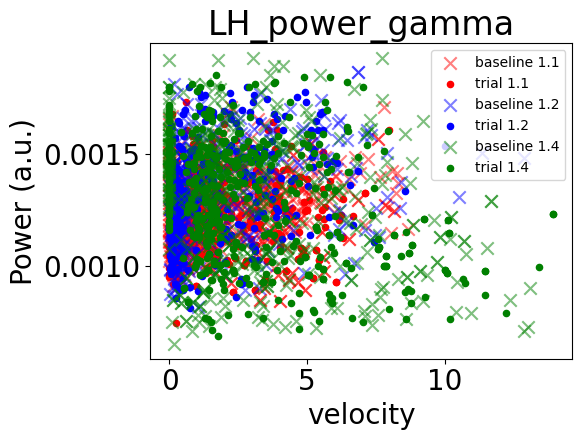

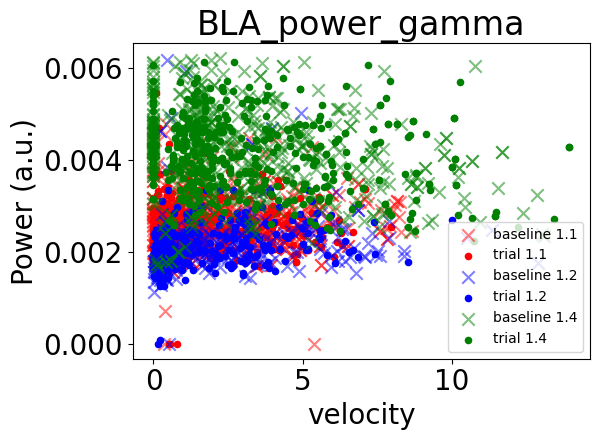

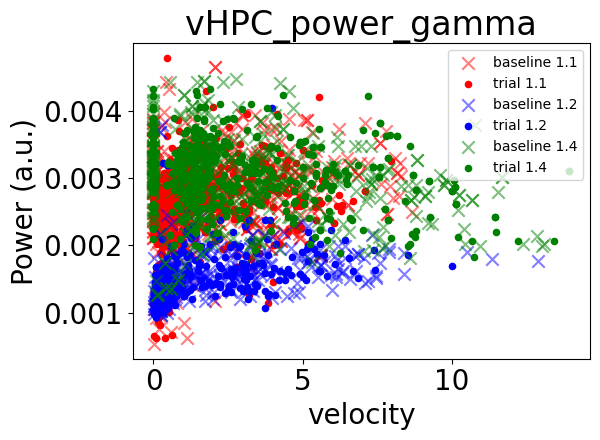

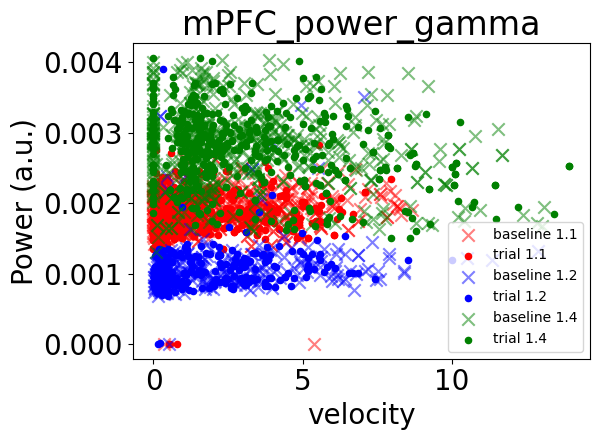

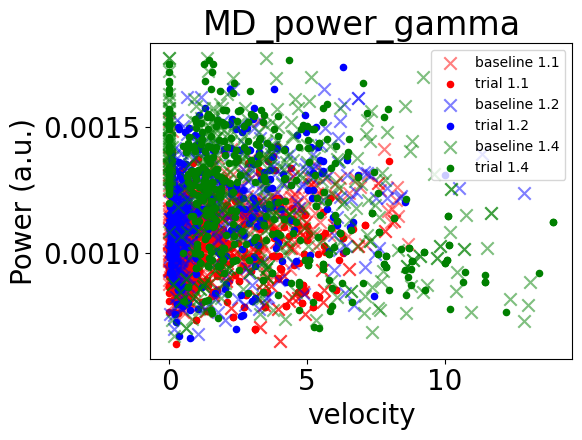

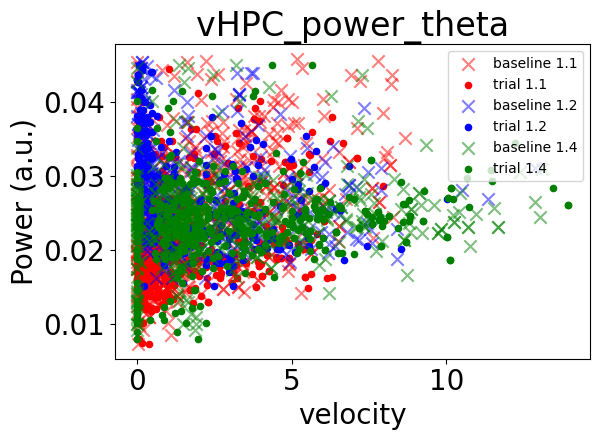

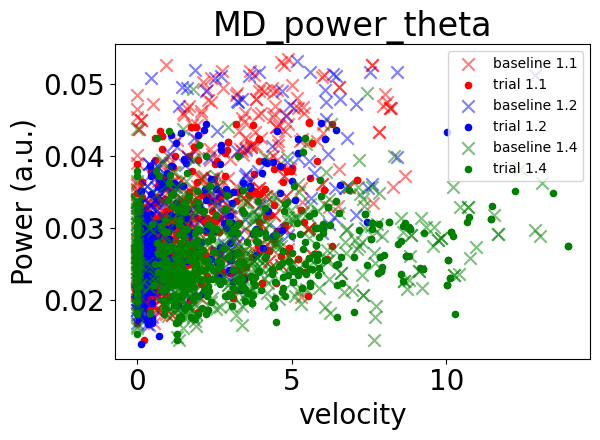

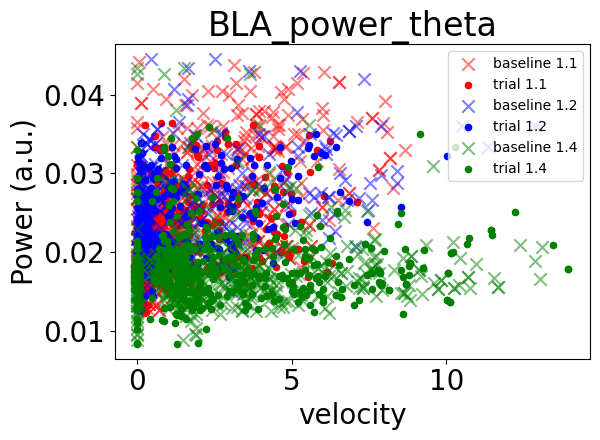

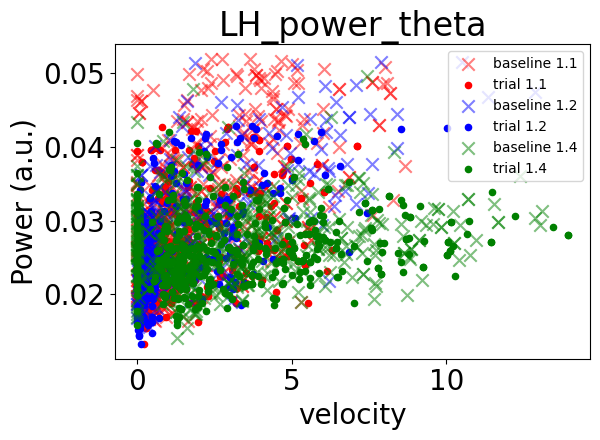

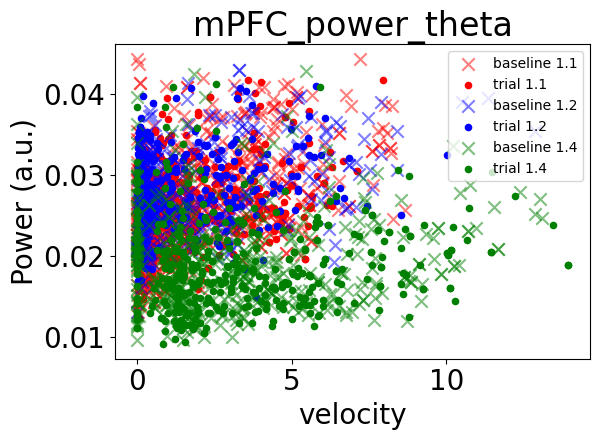

In [32]:
for power_col in power_columns:
    trial_rows = LFP_SPECTRAL_DF.copy()
    baseline_power_col = "baseline_{}".format(power_col)
    trial_power_col = "trial_{}".format(power_col)

    trial_rows[baseline_power_col] = trial_rows[baseline_power_col].apply(lambda x: np.nanmean(x))
    trial_rows[trial_power_col] = trial_rows[trial_power_col].apply(lambda x: np.nanmean(x))
    trial_rows["baseline_subject_thorax_velocity"] = trial_rows["baseline_subject_thorax_velocity"].apply(lambda x: np.nanmean(x))
    trial_rows["trial_subject_thorax_velocity"] = trial_rows["trial_subject_thorax_velocity"].apply(lambda x: np.nanmean(x))

    # Calculate Q1, Q3 and IQR
    Q1 = trial_rows[trial_power_col].quantile(0.25)
    Q3 = trial_rows[trial_power_col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    trial_lower_bound = Q1 - 1.5 * IQR
    trial_upper_bound = Q3 + 1.5 * IQR
    
    # Calculate Q1, Q3 and IQR
    Q1 = trial_rows[baseline_power_col].quantile(0.25)
    Q3 = trial_rows[baseline_power_col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    baseline_lower_bound = Q1 - 1.5 * IQR
    baseline_upper_bound = Q3 + 1.5 * IQR

    # Non-outlier values
    trial_rows = trial_rows[(trial_rows[trial_power_col] >= trial_lower_bound) & (trial_rows[trial_power_col] <= trial_upper_bound)]
    trial_rows = trial_rows[(trial_rows[baseline_power_col] >= baseline_lower_bound) & (trial_rows[baseline_power_col] <= baseline_upper_bound)]

    # trial_rows = trial_rows[(np.abs(stats.zscore(trial_rows[[power_col, "baseline_subject_thorax_velocity"]])) < 3).all(axis=1)]
    fig, ax = plt.subplots()
    plt.title(power_col)
    # print(trial_rows["baseline_subject_thorax_velocity"])
    # plt.scatter(trial_rows["baseline_subject_thorax_velocity"], trial_rows[baseline_power_col], label="baseline".format(), color="red", marker="x", alpha=0.5, s=80)
    # plt.scatter(trial_rows["trial_subject_thorax_velocity"], trial_rows[trial_power_col], label="trial".format(), color="blue", marker=".", s=80)
    
    for subj in trial_rows["current_subject"].unique():
        subj_rows = trial_rows[trial_rows["current_subject"] == subj]
        plt.scatter(subj_rows["baseline_subject_thorax_velocity"], subj_rows[baseline_power_col], label="baseline {}".format(subj), color=id_to_color[subj], marker="x", alpha=0.5, s=80)
        plt.scatter(subj_rows["trial_subject_thorax_velocity"], subj_rows[trial_power_col], label="trial {}".format(subj), color=id_to_color[subj], marker=".", s=80)
    
    
    plt.legend(fontsize=10)
    plt.xlabel("velocity")
    plt.ylabel("Power (a.u.)")
    plt.tight_layout()
    plt.savefig("./proc/plots/power_velocity_scatter/png/velocity_to_{}.png".format(power_col))
    plt.savefig("./proc/plots/power_velocity_scatter/svg/velocity_to_{}.svg".format(power_col))

    plt.show()
        
        
    



In [33]:
region_to_correlation = {}

for power_col in power_columns:
    trial_rows = LFP_SPECTRAL_DF.copy()
    baseline_power_col = "baseline_{}".format(power_col)
    trial_power_col = "trial_{}".format(power_col)

    trial_rows[baseline_power_col] = trial_rows[baseline_power_col].apply(lambda x: np.nanmean(x))
    trial_rows[trial_power_col] = trial_rows[trial_power_col].apply(lambda x: np.nanmean(x))
    trial_rows["baseline_subject_thorax_velocity"] = trial_rows["baseline_subject_thorax_velocity"].apply(lambda x: np.nanmean(x))
    trial_rows["trial_subject_thorax_velocity"] = trial_rows["trial_subject_thorax_velocity"].apply(lambda x: np.nanmean(x))

    # Calculate Q1, Q3 and IQR
    Q1 = trial_rows[trial_power_col].quantile(0.25)
    Q3 = trial_rows[trial_power_col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    trial_lower_bound = Q1 - 1.5 * IQR
    trial_upper_bound = Q3 + 1.5 * IQR
    
    # Calculate Q1, Q3 and IQR
    Q1 = trial_rows[baseline_power_col].quantile(0.25)
    Q3 = trial_rows[baseline_power_col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    baseline_lower_bound = Q1 - 1.5 * IQR
    baseline_upper_bound = Q3 + 1.5 * IQR

    # Non-outlier values
    trial_rows = trial_rows[(trial_rows[trial_power_col] >= trial_lower_bound) & (trial_rows[trial_power_col] <= trial_upper_bound)]
    trial_rows = trial_rows[(trial_rows[baseline_power_col] >= baseline_lower_bound) & (trial_rows[baseline_power_col] <= baseline_upper_bound)]
    
    region_to_correlation[power_col] = {"baseline": scipy.stats.pearsonr(trial_rows["baseline_subject_thorax_velocity"], trial_rows[baseline_power_col]), "trial": scipy.stats.pearsonr(trial_rows["trial_subject_thorax_velocity"], trial_rows[trial_power_col])}

        
        
    




In [34]:
correlation_df = pd.DataFrame.from_dict(region_to_correlation, orient="index")

In [35]:
correlation_df["baseline_pearson"] = correlation_df["baseline"].apply(lambda x: x[0]).astype(np.float16)
correlation_df["baseline_pvalue"] = correlation_df["baseline"].apply(lambda x: x[1]).astype(np.float16)
correlation_df["trial_pearson"] = correlation_df["trial"].apply(lambda x: x[0]).astype(np.float16)
correlation_df["trial_pvalue"] = correlation_df["trial"].apply(lambda x: x[1]).astype(np.float16)

In [36]:
correlation_df = correlation_df.drop(columns = ["baseline", "trial"], errors="ignore")

In [37]:
correlation_df

baseline_pearson  baseline_pvalue  trial_pearson  \
LH_power_gamma           -0.018951         0.495605      -0.076721   
BLA_power_gamma           0.152100         0.000000       0.263184   
vHPC_power_gamma          0.162476         0.000000       0.211182   
mPFC_power_gamma          0.168945         0.000000       0.226685   
MD_power_gamma            0.042175         0.134399      -0.006939   
vHPC_power_theta          0.113953         0.000070       0.094849   
MD_power_theta            0.311279         0.000000       0.185303   
BLA_power_theta           0.099609         0.000395      -0.014359   
LH_power_theta            0.346436         0.000000       0.271240   
mPFC_power_theta          0.106995         0.000133      -0.133423   

                  trial_pvalue  
LH_power_gamma        0.005737  
BLA_power_gamma       0.000000  
vHPC_power_gamma      0.000000  
mPFC_power_gamma      0.000000  
MD_power_gamma        0.805664  
vHPC_power_theta      0.000943  
MD_power_theta        0.000000  
BLA_power_theta       0.610352  
LH_power_theta        0.000000  
mPFC_power_theta      0.000002

In [38]:
power_col

'mPFC_power_theta'

In [39]:
Path("./proc/plots/power_velocity_scatter/png").mkdir(parents=True, exist_ok=True)
Path("./proc/plots/power_velocity_scatter/svg").mkdir(parents=True, exist_ok=True)

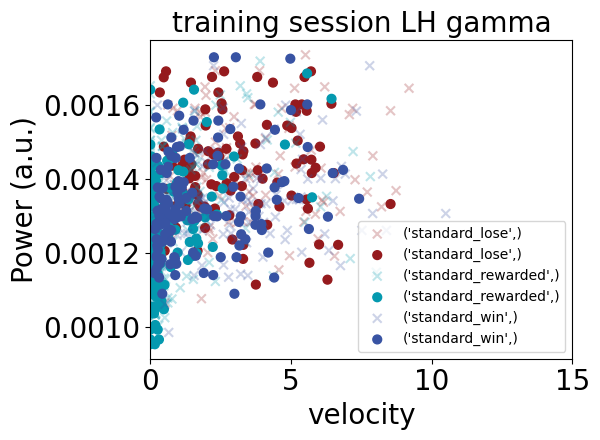

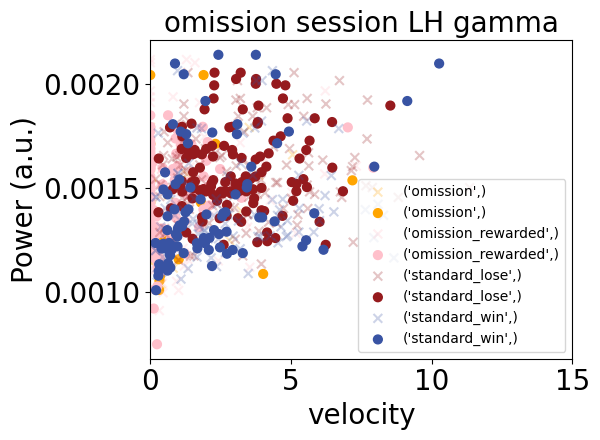

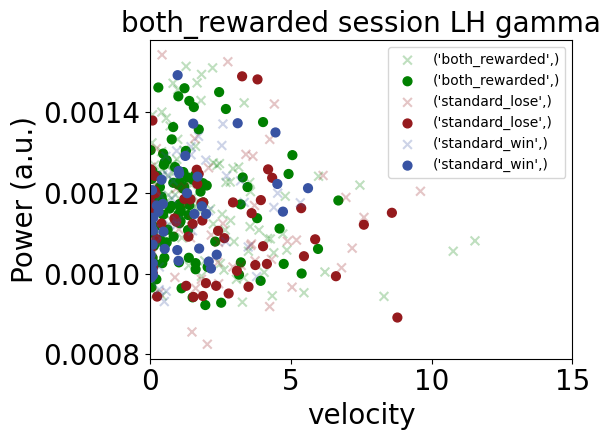

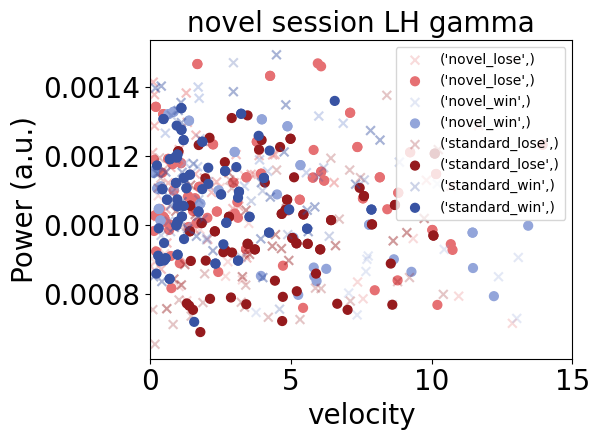

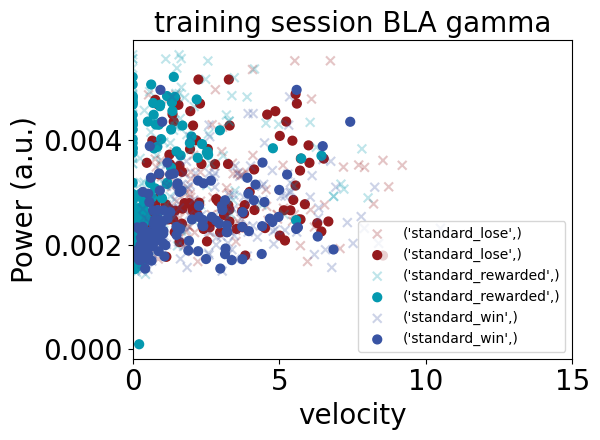

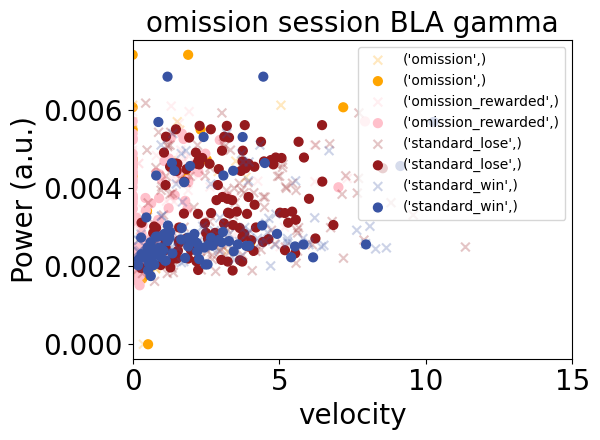

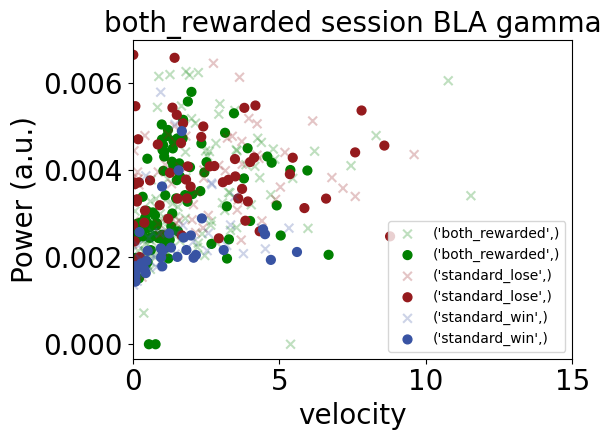

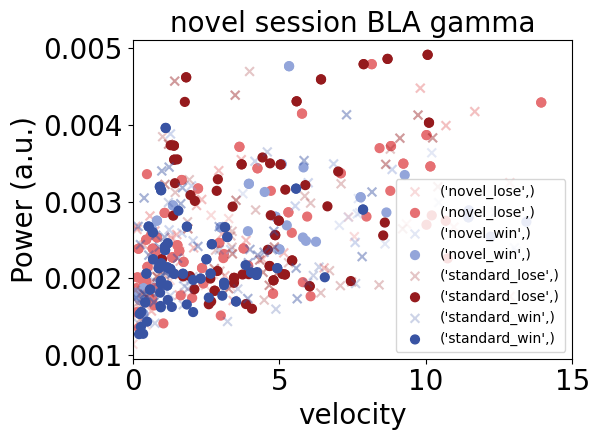

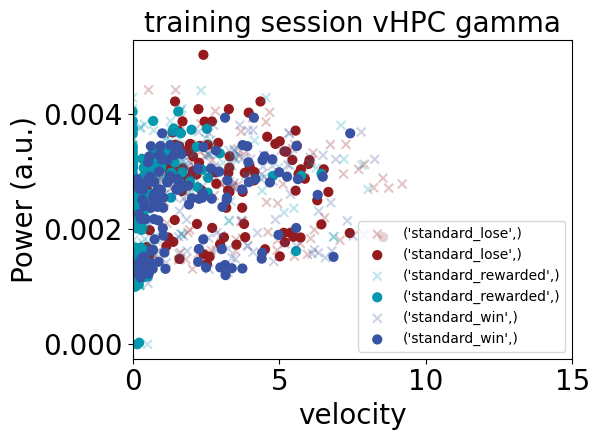

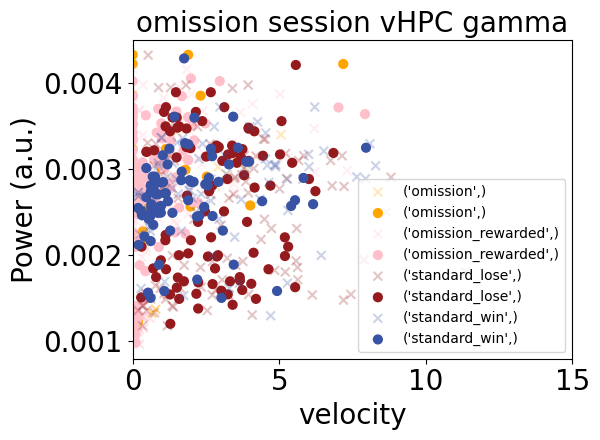

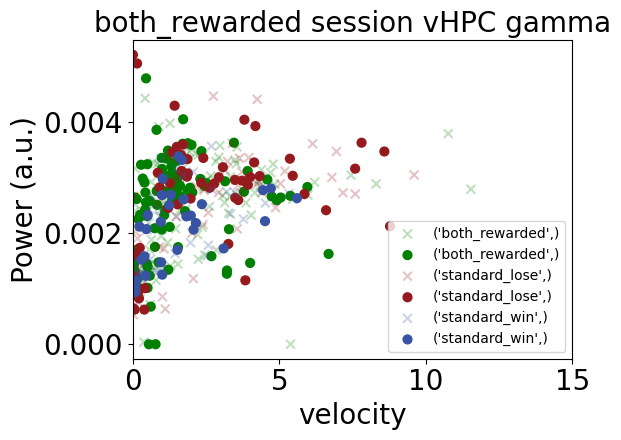

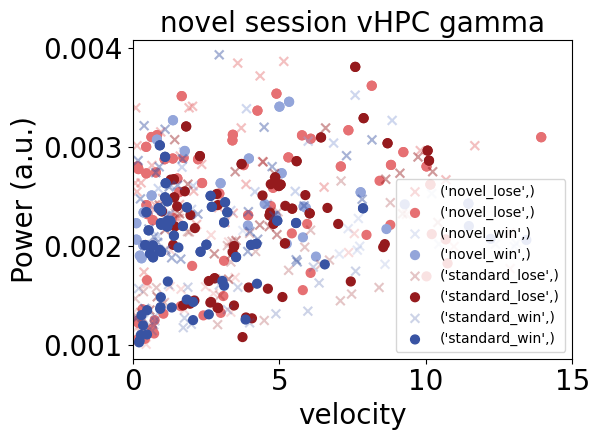

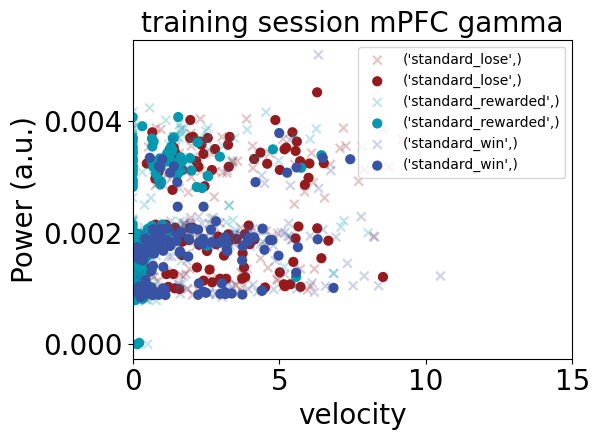

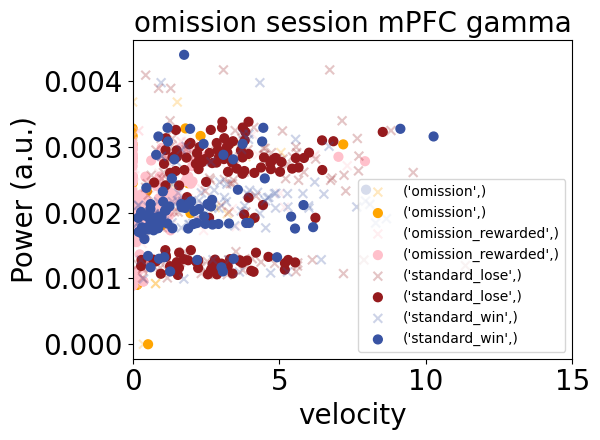

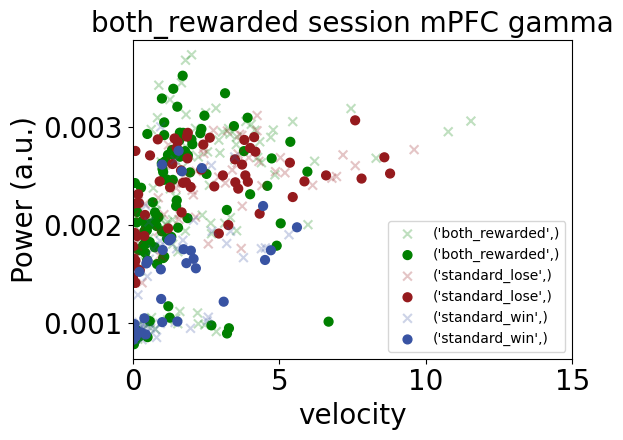

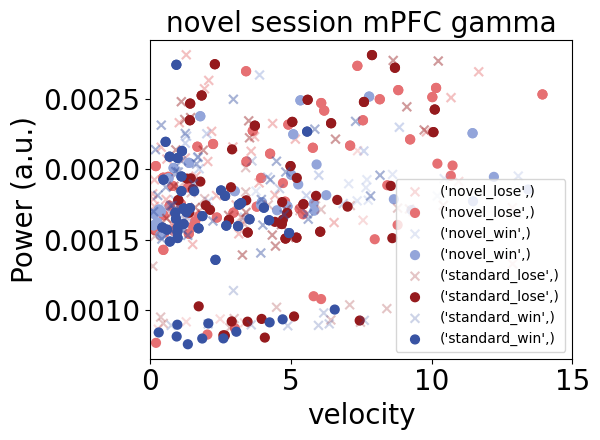

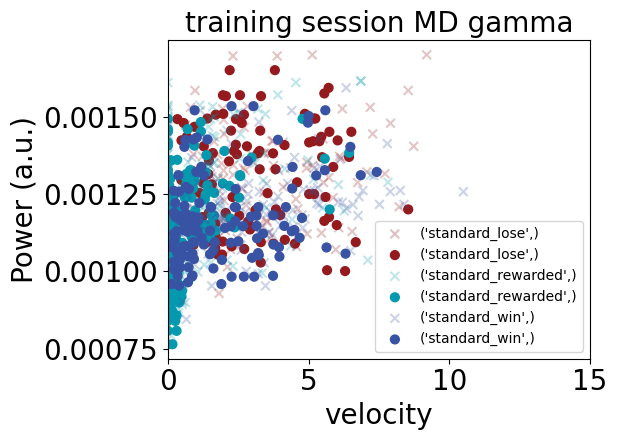

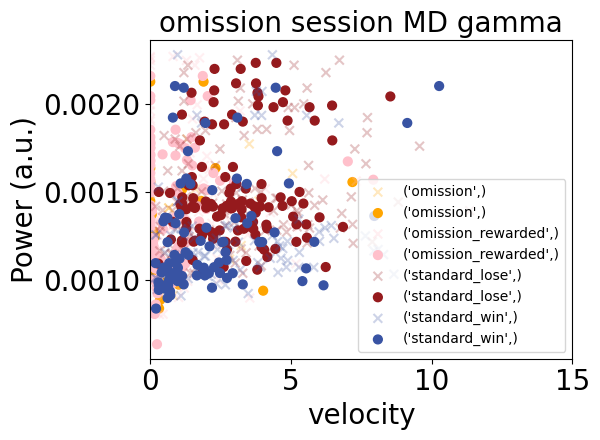

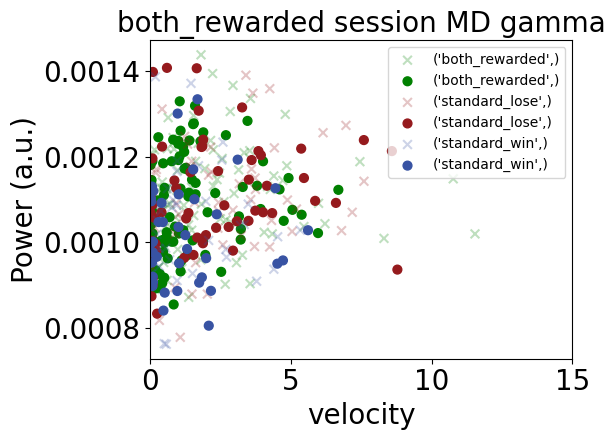

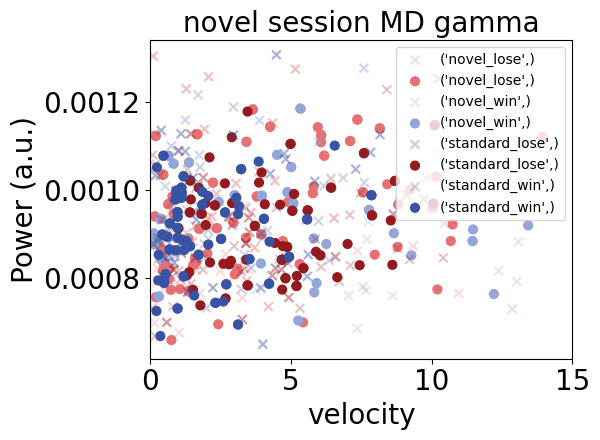

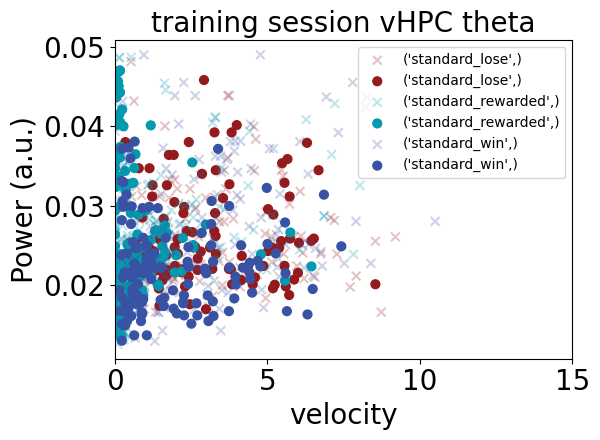

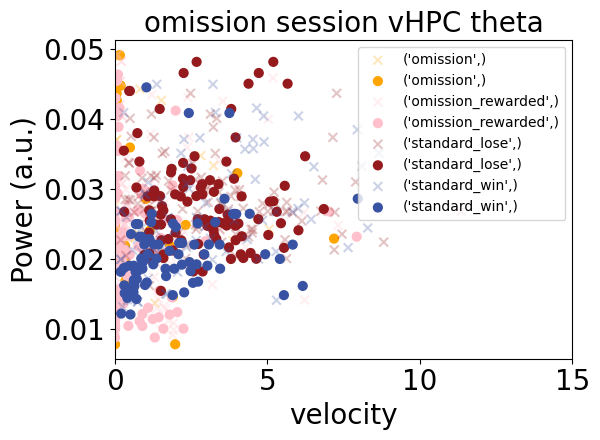

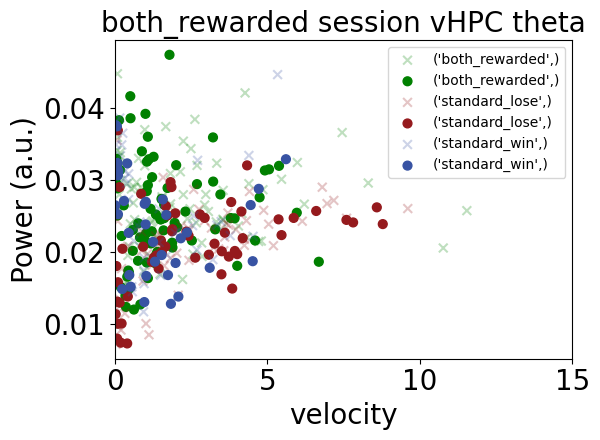

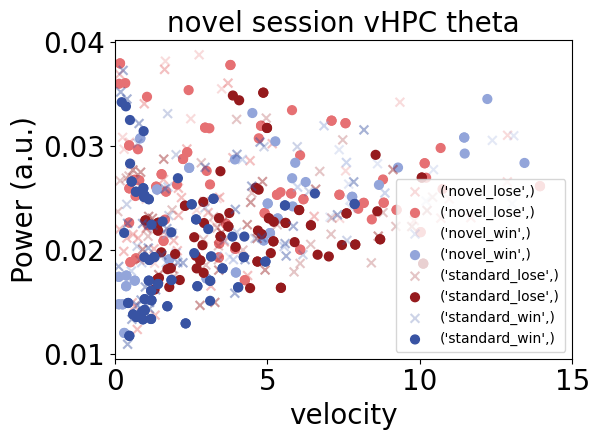

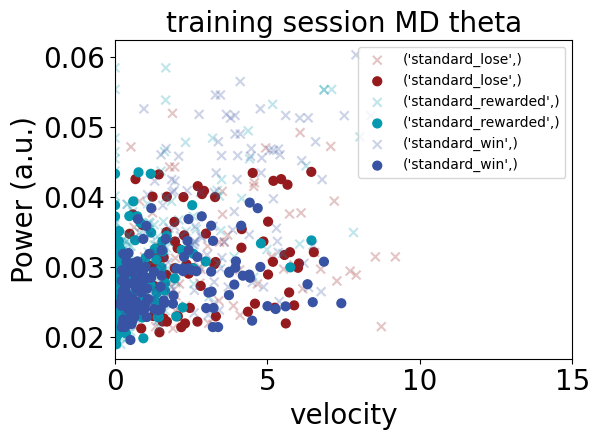

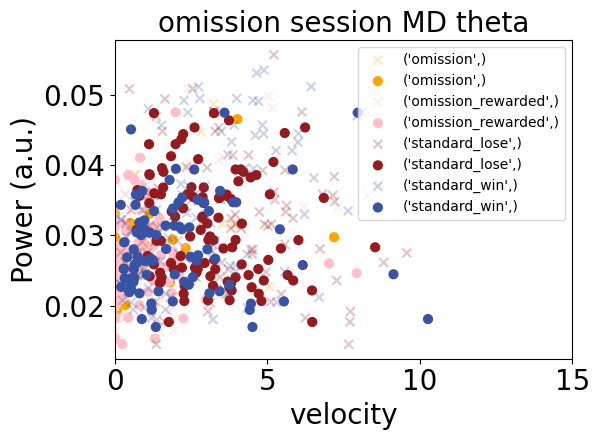

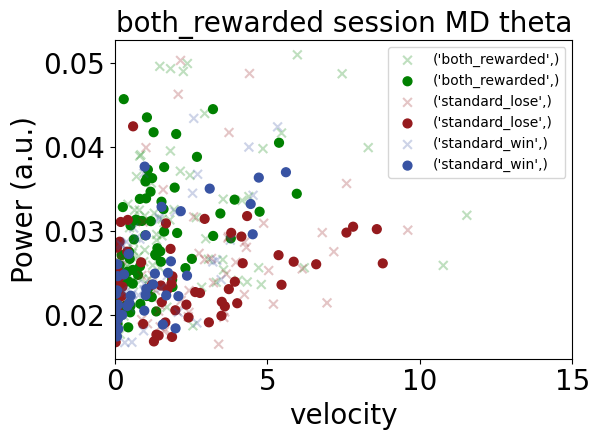

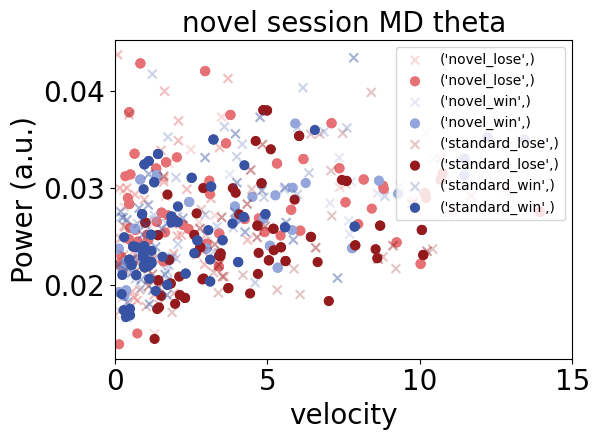

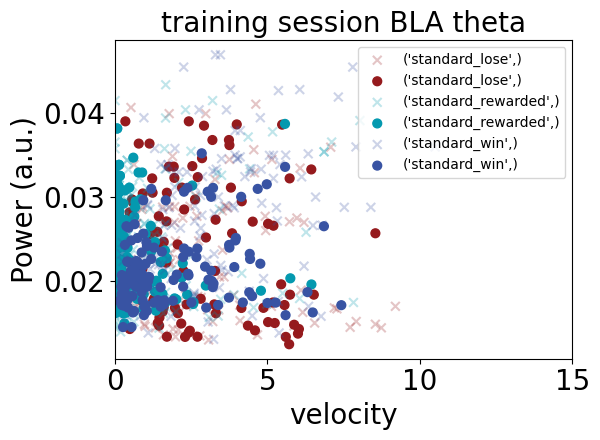

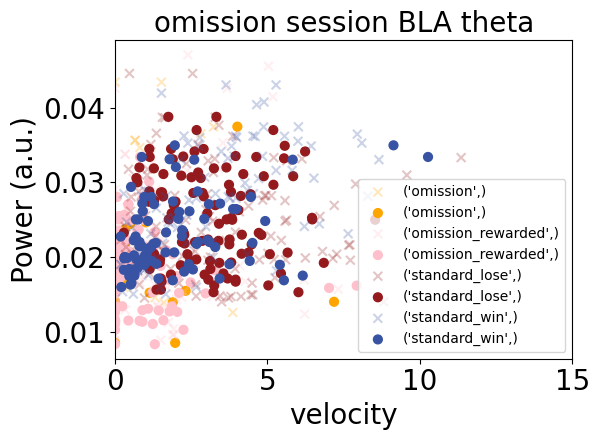

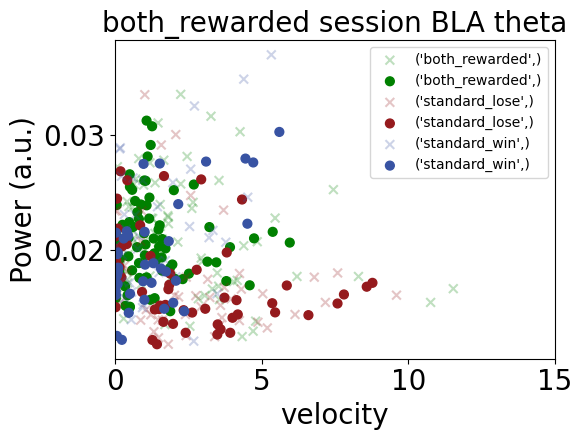

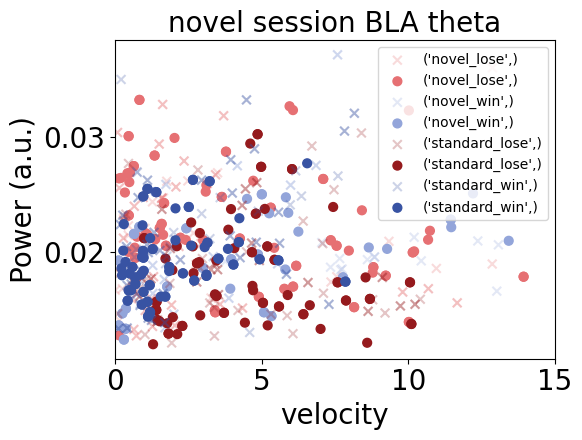

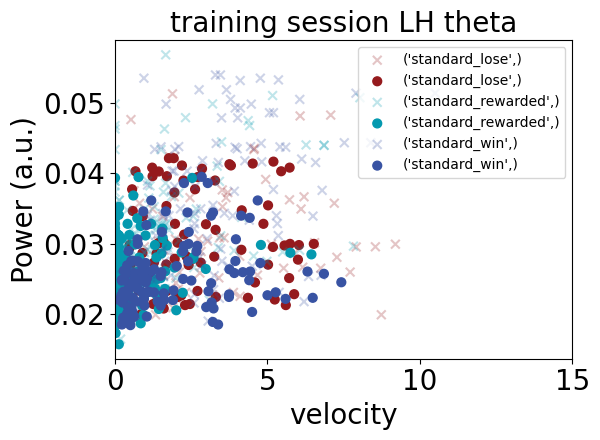

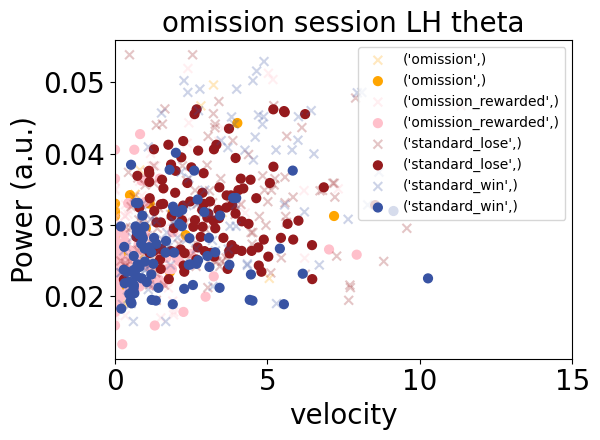

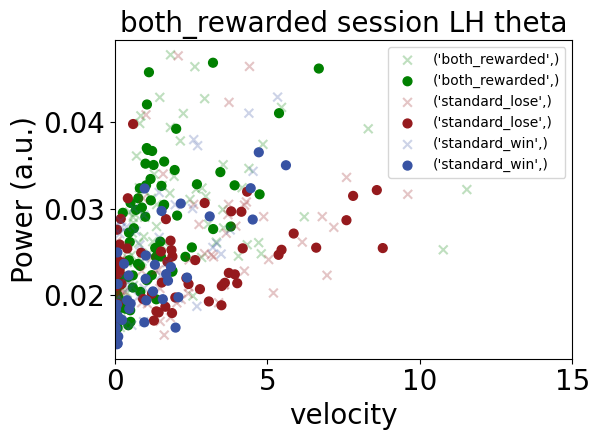

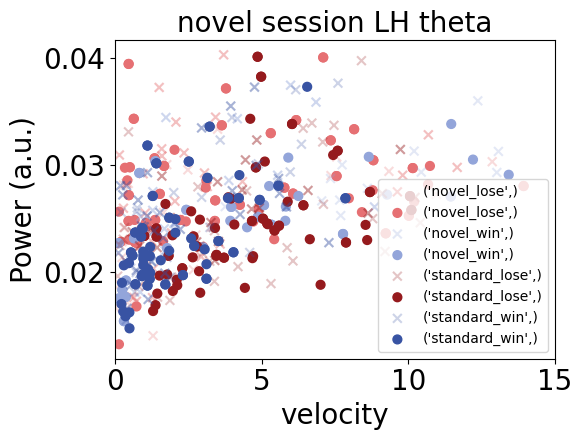

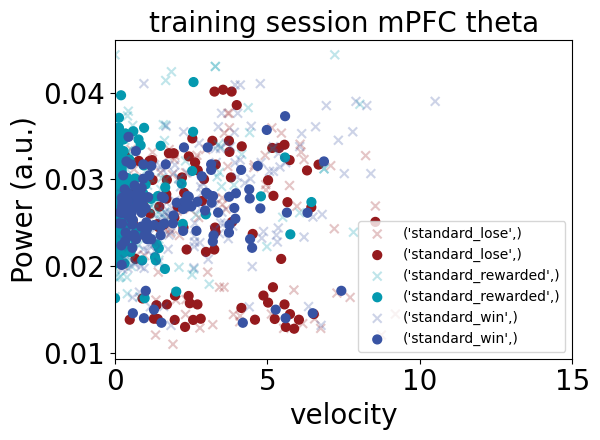

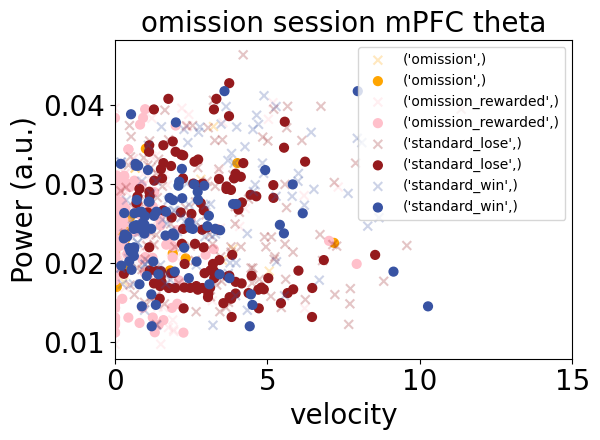

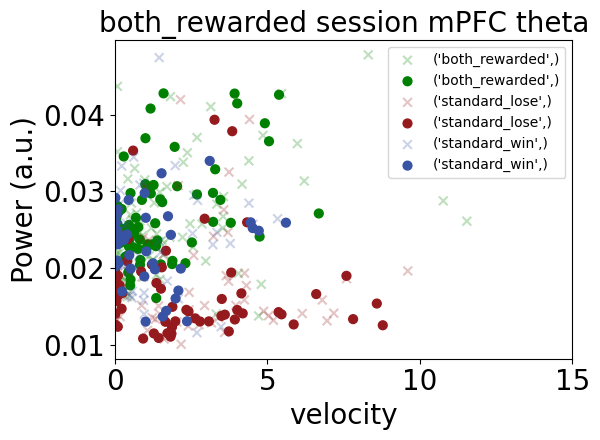

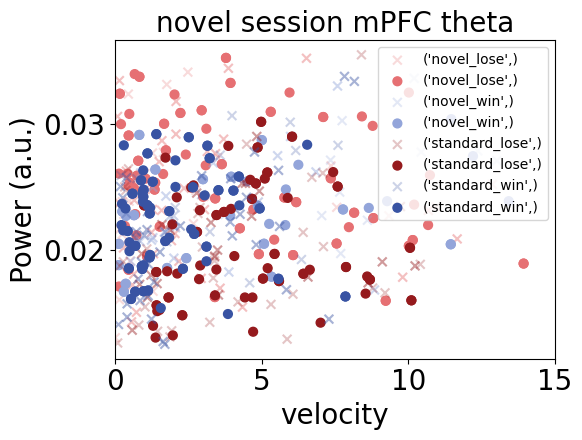

In [40]:
for power_col in power_columns:
    for trial_label in session_types:
        trial_rows = LFP_SPECTRAL_DF[LFP_SPECTRAL_DF["recording"].str.contains(trial_label)]
        baseline_power_col = "baseline_{}".format(power_col)
        trial_power_col = "trial_{}".format(power_col)
        
        trial_rows[baseline_power_col] = trial_rows[baseline_power_col].apply(lambda x: np.nanmean(x))
        trial_rows[trial_power_col] = trial_rows[trial_power_col].apply(lambda x: np.nanmean(x))
        trial_rows["baseline_subject_thorax_velocity"] = trial_rows["baseline_subject_thorax_velocity"].apply(lambda x: np.nanmean(x))
        trial_rows["trial_subject_thorax_velocity"] = trial_rows["trial_subject_thorax_velocity"].apply(lambda x: np.nanmean(x))
        
        trial_rows["color"] = trial_rows["experiment_and_label"].map(OUTCOME_TO_COLOR)
        
        # Calculate Q1, Q3 and IQR
        Q1 = trial_rows[trial_power_col].quantile(0.25)
        Q3 = trial_rows[trial_power_col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        trial_lower_bound = Q1 - 1.5 * IQR
        trial_upper_bound = Q3 + 1.5 * IQR

        # Calculate Q1, Q3 and IQR
        Q1 = trial_rows[baseline_power_col].quantile(0.25)
        Q3 = trial_rows[baseline_power_col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        baseline_lower_bound = Q1 - 1.5 * IQR
        baseline_upper_bound = Q3 + 1.5 * IQR

        # Non-outlier values
        trial_rows = trial_rows[(trial_rows[trial_power_col] >= trial_lower_bound) & (trial_rows[trial_power_col] <= trial_upper_bound)]
        trial_rows = trial_rows[(trial_rows[baseline_power_col] >= baseline_lower_bound) & (trial_rows[baseline_power_col] <= baseline_upper_bound)]

        # trial_rows = trial_rows[(np.abs(stats.zscore(trial_rows[[power_col, "baseline_subject_thorax_velocity"]])) < 3).all(axis=1)]
        fig, ax = plt.subplots()
        plt.title("{} session {}".format(trial_label, " ".join(power_col.split("_power_"))), fontsize=20)
        # print(trial_rows["baseline_subject_thorax_velocity"])
        
      
        # Iterate over the unique values in the 'label' column
        for label, group_df in trial_rows.groupby(["experiment_and_label"]):
            ax.scatter(group_df["baseline_subject_thorax_velocity"], group_df[baseline_power_col], label=label, color=group_df["color"], marker="x", alpha=0.25, s=40)
            ax.scatter(group_df["trial_subject_thorax_velocity"], group_df[trial_power_col], label=label, color=group_df["color"], marker=".", s=160)
        
        plt.legend(fontsize=10)
        plt.xlabel("velocity", fontsize=20)
        plt.ylabel("Power (a.u.)", fontsize=20)
        plt.xlim(0, 15)

        plt.tight_layout()
        plt.savefig("./proc/plots/power_velocity_scatter/png/{}_velocity_to_{}.png".format(trial_label, power_col))
        plt.savefig("./proc/plots/power_velocity_scatter/svg/{}_velocity_to_{}.svg".format(trial_label, power_col))

        plt.show()
        
        
    

